In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

In [2]:
df = pd.read_csv('Reviews.csv')
df = df.head(500)

print(df.shape)

(500, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<h3><B>EDA

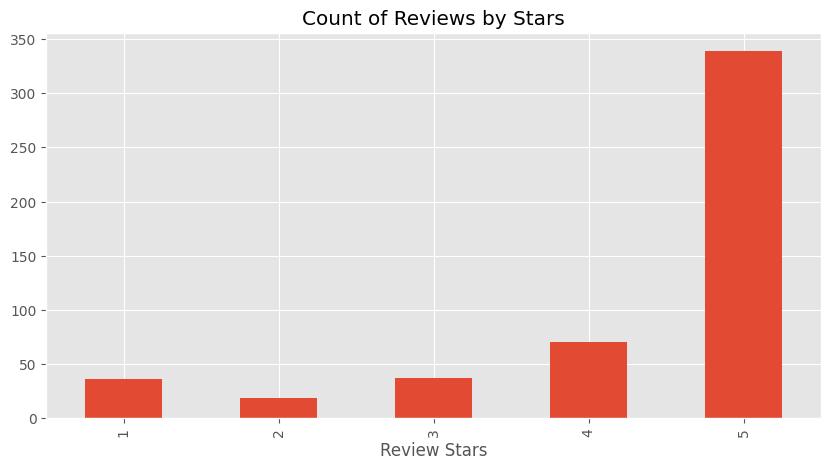

In [4]:
ax = df['Score'].value_counts().sort_index()\
    .plot(kind='bar',
    title='Count of Reviews by Stars',
    figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

<h3><b>NLP

In [5]:
ex = df['Text'][50]
print(ex)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
tk = nltk.word_tokenize(ex)
tk[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
pos = nltk.pos_tag(tk)
pos[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [8]:
ent = nltk.chunk.ne_chunk(pos)
ent.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


<h3>Step 1: VADER Sentiment Scoring

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('worst bad rejected')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.8979}

In [11]:
sia.polarity_scores('good happy best')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.8957}

In [12]:
ex

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [13]:
sia.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

Now running the polarity score on the entire dataset

In [14]:
res = {} #Result dictionary which will store the polarity scores as dictionary
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

Making result dictionary 'res' a pandas dataframe

In [17]:
vader = pd.DataFrame(res).T
vader.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [18]:
vader.tail()

,neg,neu,pos,compound
496,0.000,0.554,0.446,0.9725
497,0.059,0.799,0.142,0.7833
498,0.025,0.762,0.212,0.9848
499,0.041,0.904,0.055,0.1280
500,0.000,0.678,0.322,0.9811


In [19]:
vader =vader.reset_index().rename(columns={'index':'Id'})
vader = vader.merge(df, how='left')

In [20]:
#Sentiment score and metadata
vader.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


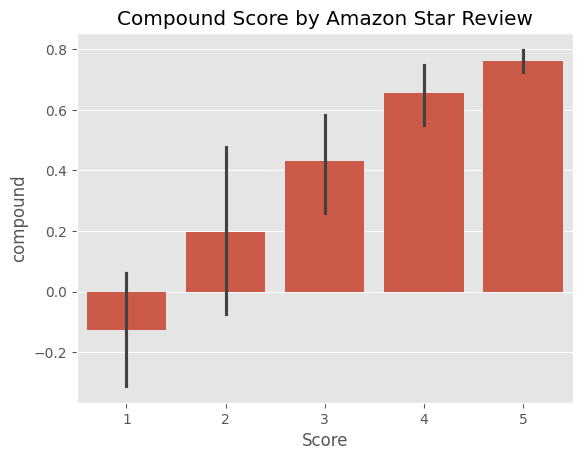

In [21]:
ax1 = sns.barplot(data=vader, x='Score', y='compound')
ax1.set_title('Compound Score by Amazon Star Review')
plt.show()

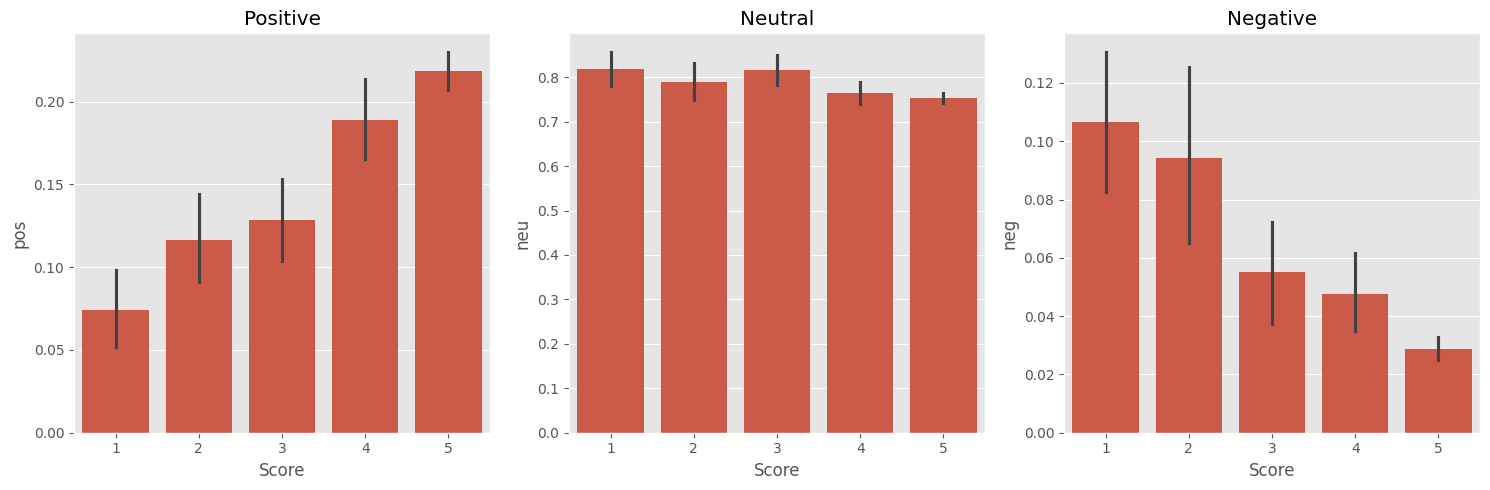

In [22]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.barplot(data = vader, x='Score', y='pos', ax = axs[0])
sns.barplot(data = vader, x='Score', y='neu', ax = axs[1])
sns.barplot(data = vader, x='Score', y='neg', ax = axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout()

plt.show()

<h3><B>RoBERTa Pretrained Model

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
#Our example sentiment
print(ex)
sia.polarity_scores(ex)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [26]:
#Run for RoBERTa model

enc_text = tokenizer(ex, return_tensors='pt')
output = model(**enc_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg':scores[0],
    'roberta_ney':scores[1],
    'roberta_pos':scores[2],
}

print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_ney': 0.020687453, 'roberta_pos': 0.0029573692}


<i>According to RoBERTa model, our example line is more negative than what our VADER model thought

In [27]:
#Running the model for whole dataset

def pol_roberta(ex):
    enc_text = tokenizer(ex, return_tensors='pt')
    output = model(**enc_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }

    return scores_dict

In [28]:
res = {} #Result dictionary which will store the polarity scores as dictionary
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)

        vad_result_rename = {}
        for key, value in vader_result.items():
            vad_result_rename[f"vader_{key}"] = value

        roberta_result = pol_roberta(text)

        both = {**vader_result,**roberta_result}

        res[myid] = both

    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id83
Broke for id187


In [31]:
result_df = pd.DataFrame(res).T
result_df.head()

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600
3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063


In [32]:
result_df = result_df.reset_index().rename(columns={'index':'Id'})
result_df = result_df.merge(df, how='left')

In [33]:
result_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<h3><b>Score comparision

In [34]:
result_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

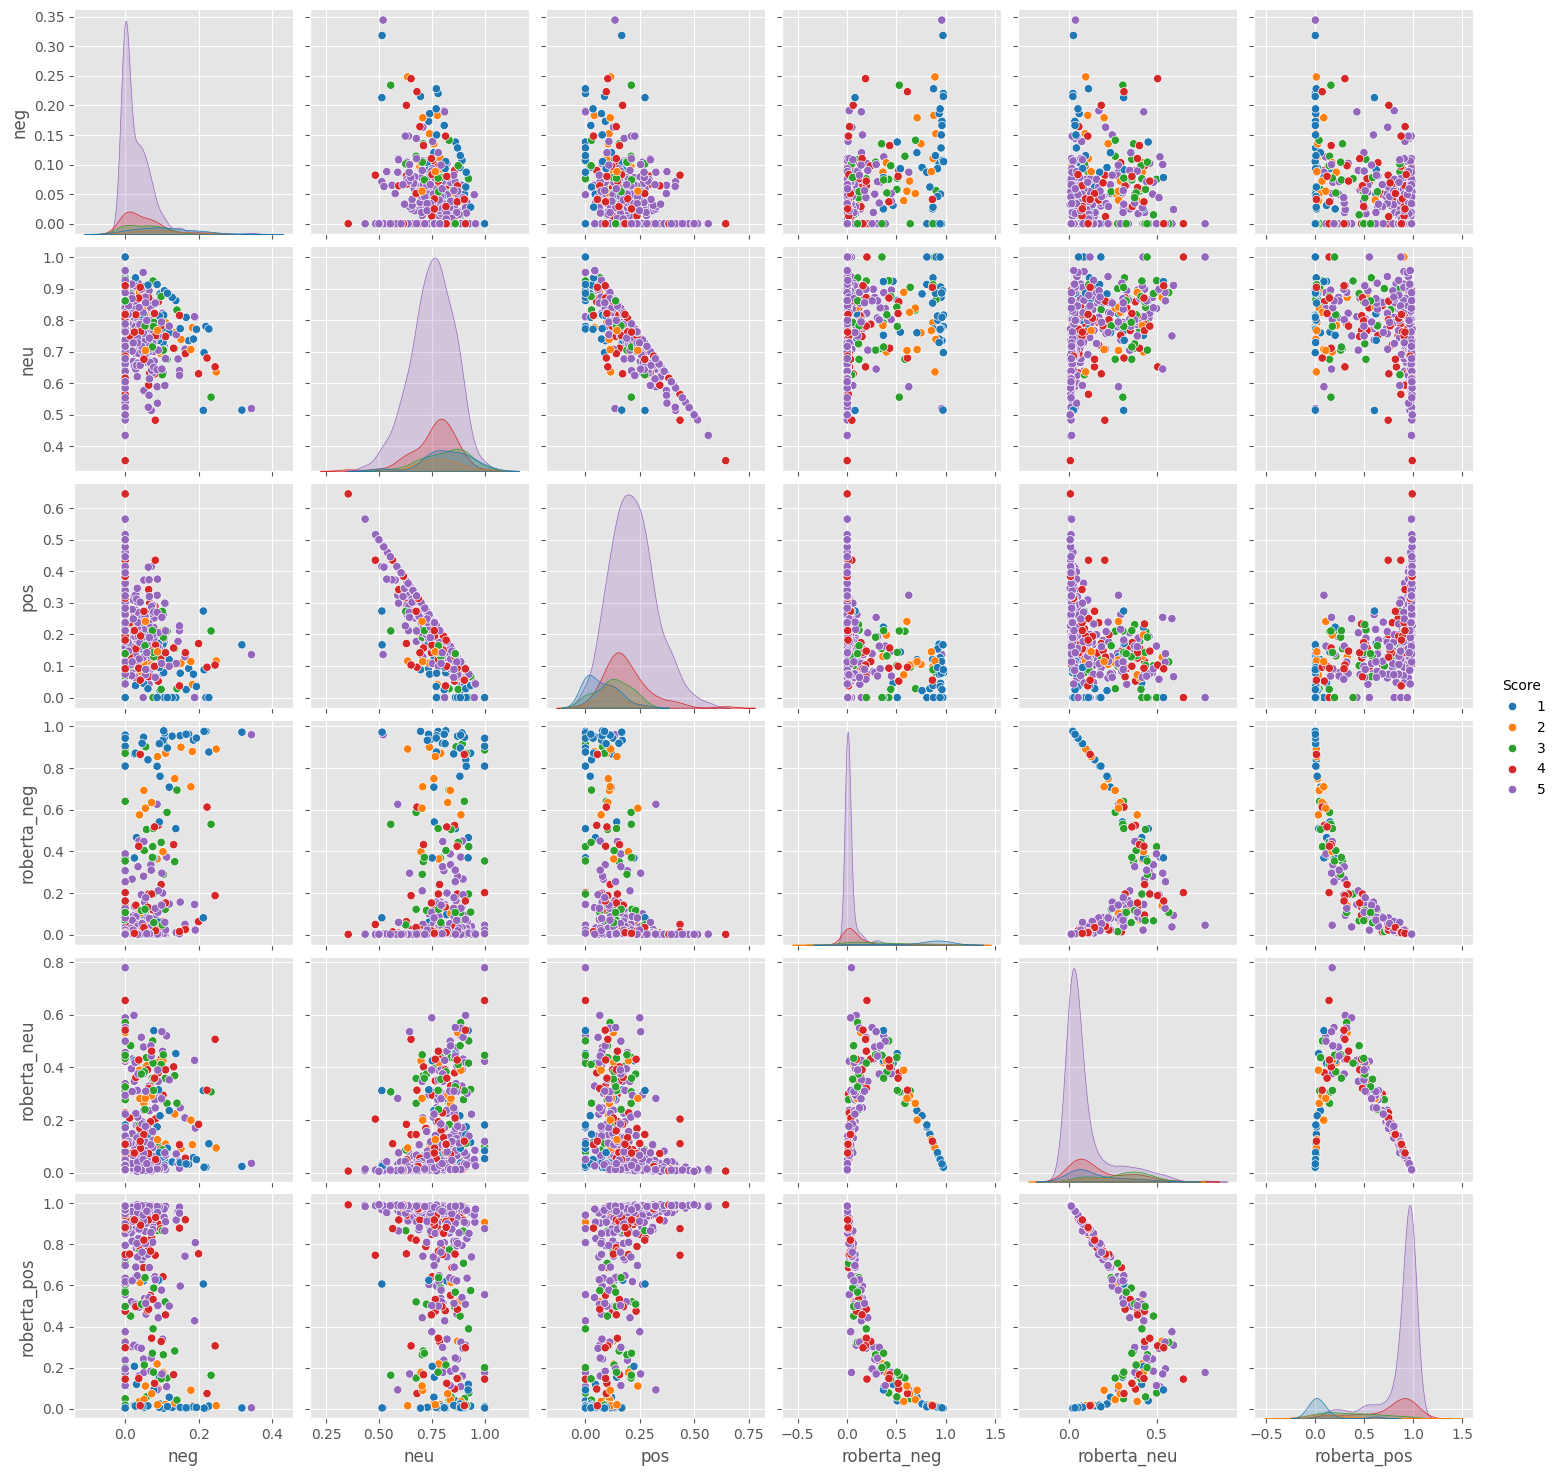

In [35]:
sns.pairplot(data=result_df,
             vars=['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu',
       'roberta_pos'],
       hue='Score',
       palette='tab10')

plt.show()

<h2><b>Review Examples

In [36]:
#positive sentiment with 1 star review
result_df.query('Score==1')\
    .sort_values('roberta_pos', ascending=False)['Text'].values[0] 

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [37]:
result_df.query('Score==1')\
    .sort_values('pos', ascending=False)['Text'].values[0] 

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [38]:
#negative sentiment 5 star review

result_df.query('Score==5')\
    .sort_values('roberta_neg', ascending=False)['Text'].values[0] 

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [39]:
result_df.query('Score==5')\
    .sort_values('neg', ascending=False)['Text'].values[0] 

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

<h2><b>Using HuggingFace Transformers Pipeline

In [41]:
from transformers import pipeline
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [42]:
pipe(ex)

[{'label': 'NEGATIVE', 'score': 0.9994776844978333}]

In [43]:
res2 = {} #Result dictionary which will store the sentiments
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        
        res2[myid] = pipe(text)

    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


Broke for id83
Broke for id187


In [44]:
#creating a data frame of the result 'res2'
pipe_result = pd.DataFrame(res2).T
pipe_result.head()

,0
1,"{'label': 'POSITIVE', 'score': 0.9983851909637..."
2,"{'label': 'NEGATIVE', 'score': 0.9995254278182..."
3,"{'label': 'POSITIVE', 'score': 0.9997652173042..."
4,"{'label': 'POSITIVE', 'score': 0.9991534948348..."
5,"{'label': 'POSITIVE', 'score': 0.9987082481384..."
